In [156]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# 
# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

> Task summary - 

To forecast future web traffic as time series for approximately 145,000 wikipedia articles.

> Concepts

- Univariate models are statistical analysis approaches that involve the analysis of a single dependent variable. Only one variable varies over time. For ex- Sensor measuring temperature of a room per second.

- Multi variate analysis examines two or more dependent variables and multiple independent variables. Multiple variables are varying over time

- Time series is a data that occurs chronologically one after the other.
- Time series forecasting is using the data of the past to detect the future.
- Forecasting values in dynamic system(i.e source of values is dynamic) is hard.
- Every being, global event, their lives are dynamic system for the web traffic. For example - Whenever a semester starts in a university then that corresponding major's wikipedia may be getting a hit to know more about it.

- We usually tend to remove anomaly from time series dataset i.e abnormal behaviour.

> Steps

1. Data cleaning.
2. Visualisation.
3. Remove anomalies.
4. Apply ARMA Model.
5. Apply ARIMA Model.
6. Apply Exponential Smoothing Model.
7. Apply Prophet approach(fbprophet, future)
8. Apply Auto Arima.
9. Apply DL Model(LSTM).
10. Apply DL model(CNN1D).

In [157]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
from datetime import timedelta
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#from fbprophet import Prophet
!pip install pmdarima
from pmdarima import auto_arima

from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow import keras

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import r2_score
import re

DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


Defaulting to user installation because normal site-packages is not writeable


In [158]:
#!unzip /kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip


In [159]:
#!ls

In [160]:
data_path = "../data/train_1.csv"


In [161]:
df = pd.read_csv(data_path)
df.head()
# these are page views per days spread across various columns

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


## 1. Data Cleaning

In [162]:
# Fill missing values
df = df.fillna(0)

In [163]:
# sept to dec data
train_data = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Visits')
train_data.head()
train_data.shape

(79784650, 3)

In [164]:
train_data = train_data.sample(frac=0.2)

In [165]:
train_data['Date'] = pd.DatetimeIndex(train_data['Date'])
train_data
train_data.shape


(15956930, 3)

## 2. Data Visualization

AVERAGE NUMBER OF VIEWS PER DAYS

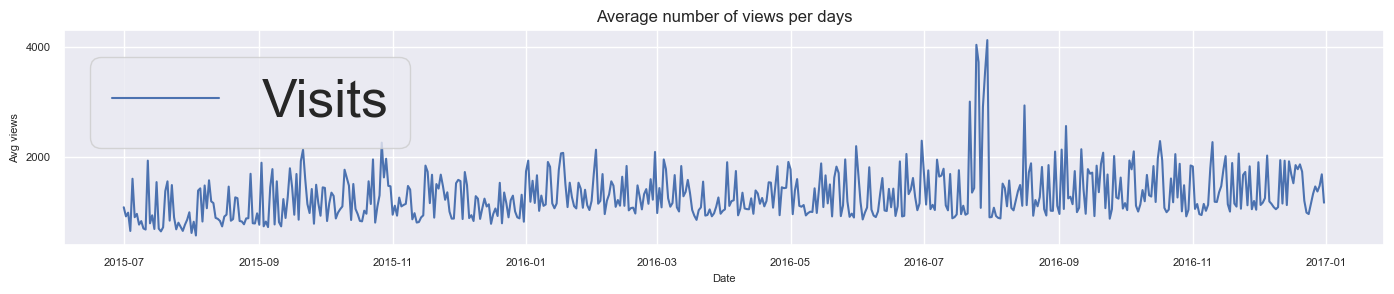

In [166]:
#visualising
temp = train_data.groupby('Date')['Visits'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date', fontsize=8)
plt.ylabel('Avg views',fontsize=8)
plt.title('Average number of views per days', fontsize=12)
plt.plot(temp,label='Visits')
plt.xticks(fontsize=8)  
plt.yticks(fontsize=8) 
plt.legend()
plt.tight_layout()
plt.show()

MEDIAN NUMBER OF VIEWS PER DAYS

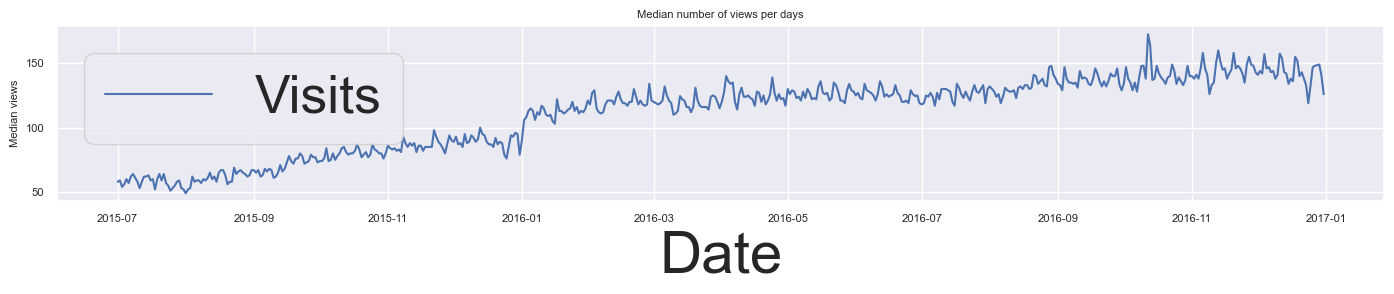

In [167]:
#visualising
temp = train_data.groupby('Date')['Visits'].median()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Median views', fontsize=8)
plt.title('Median number of views per days', fontsize=8)
plt.plot(temp,label='Visits')
plt.legend()
plt.xticks(fontsize=8)  
plt.yticks(fontsize=8) 
plt.tight_layout()
plt.show()

In [168]:
train_data

,Page,Date,Visits
25931609,Competency-based_development_en.wikipedia.org_...,2015-12-26,11.0
6044769,Homúnculo_es.wikipedia.org_mobile-web_all-agents,2015-08-11,394.0
42482337,"Беллуччи,_Моника_ru.wikipedia.org_all-access_s...",2016-04-18,24.0
40124961,ケンブリッジ飛鳥_ja.wikipedia.org_desktop_all-agents,2016-04-02,18.0
38029884,Manual:External_editors/de_www.mediawiki.org_m...,2016-03-19,5.0
...,...,...,...
47568783,荻野目洋子_ja.wikipedia.org_all-access_spider,2016-05-23,122.0
63726355,Special:RecentChangesLinked/How_to_contribute_...,2016-09-12,51.0
37885007,Andy_Schleck_fr.wikipedia.org_all-access_all-a...,2016-03-18,44.0
76392598,平野ノラ_ja.wikipedia.org_desktop_all-agents,2016-12-08,981.0


In [169]:
# EXTRACTING THE YEAR, MONTH, DATE FROM THE DATE COLUMN AND CREATING NEW COLUMNS

train_data['year']=train_data.Date.dt.year 
train_data['month']=train_data.Date.dt.month 
train_data['day']=train_data.Date.dt.day

In [170]:
#plotting web traffic over days of month using heatmap
# data is of 9th month to 12th
train_data['month_num'] = train_data['month']
train_data['month'].replace('1', '1 - January', inplace=True)
train_data['month'].replace('2', '2 - February', inplace=True)
train_data['month'].replace('3', '3 - March', inplace=True)
train_data['month'].replace('4', '4 - April', inplace=True)
train_data['month'].replace('5', '5 - May', inplace=True)
train_data['month'].replace('6', '6 - June', inplace=True)
train_data['month'].replace('7', '7 - July', inplace=True)
train_data['month'].replace('8', '8 - August', inplace=True)
train_data['month'].replace('9','9 - September',inplace=True)
train_data['month'].replace('10','10 - October',inplace=True)
train_data['month'].replace('11','11 - November',inplace=True)
train_data['month'].replace('12','12 - December',inplace=True)

In [171]:
train_data

,Page,Date,Visits,year,month,day,month_num
25931609,Competency-based_development_en.wikipedia.org_...,2015-12-26,11.0,2015,12,26,12
6044769,Homúnculo_es.wikipedia.org_mobile-web_all-agents,2015-08-11,394.0,2015,8,11,8
42482337,"Беллуччи,_Моника_ru.wikipedia.org_all-access_s...",2016-04-18,24.0,2016,4,18,4
40124961,ケンブリッジ飛鳥_ja.wikipedia.org_desktop_all-agents,2016-04-02,18.0,2016,4,2,4
38029884,Manual:External_editors/de_www.mediawiki.org_m...,2016-03-19,5.0,2016,3,19,3
...,...,...,...,...,...,...,...
47568783,荻野目洋子_ja.wikipedia.org_all-access_spider,2016-05-23,122.0,2016,5,23,5
63726355,Special:RecentChangesLinked/How_to_contribute_...,2016-09-12,51.0,2016,9,12,9
37885007,Andy_Schleck_fr.wikipedia.org_all-access_all-a...,2016-03-18,44.0,2016,3,18,3
76392598,平野ノラ_ja.wikipedia.org_desktop_all-agents,2016-12-08,981.0,2016,12,8,12


In [172]:
# CREATING A NEW COLUMN FOR THE WEEKDAY AND APPLYING A LAMBDA FUNCTION TO EXTRACT IT FROM THE DATE
train_data['weekday'] = train_data['Date'].apply(lambda x: x.weekday())


In [173]:
train_data['weekday#'] = train_data['weekday']
train_data['weekday'].replace(0,'01 - Monday',inplace=True)
train_data['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_data['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_data['weekday'].replace(3,'04 - Thursday',inplace=True)
train_data['weekday'].replace(4,'05 - Friday',inplace=True)
train_data['weekday'].replace(5,'06 - Saturday',inplace=True)
train_data['weekday'].replace(6,'07 - Sunday',inplace=True)

In [174]:
train_data


,Page,Date,Visits,year,month,day,month_num,weekday,weekday#
25931609,Competency-based_development_en.wikipedia.org_...,2015-12-26,11.0,2015,12,26,12,06 - Saturday,5
6044769,Homúnculo_es.wikipedia.org_mobile-web_all-agents,2015-08-11,394.0,2015,8,11,8,02 - Tuesday,1
42482337,"Беллуччи,_Моника_ru.wikipedia.org_all-access_s...",2016-04-18,24.0,2016,4,18,4,01 - Monday,0
40124961,ケンブリッジ飛鳥_ja.wikipedia.org_desktop_all-agents,2016-04-02,18.0,2016,4,2,4,06 - Saturday,5
38029884,Manual:External_editors/de_www.mediawiki.org_m...,2016-03-19,5.0,2016,3,19,3,06 - Saturday,5
...,...,...,...,...,...,...,...,...,...
47568783,荻野目洋子_ja.wikipedia.org_all-access_spider,2016-05-23,122.0,2016,5,23,5,01 - Monday,0
63726355,Special:RecentChangesLinked/How_to_contribute_...,2016-09-12,51.0,2016,9,12,9,01 - Monday,0
37885007,Andy_Schleck_fr.wikipedia.org_all-access_all-a...,2016-03-18,44.0,2016,3,18,3,05 - Friday,4
76392598,平野ノラ_ja.wikipedia.org_desktop_all-agents,2016-12-08,981.0,2016,12,8,12,04 - Thursday,3


In [175]:
train_group = train_data.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group = train_group.pivot(index='weekday', columns='month', values='Visits')
train_group.sort_index(inplace=True)

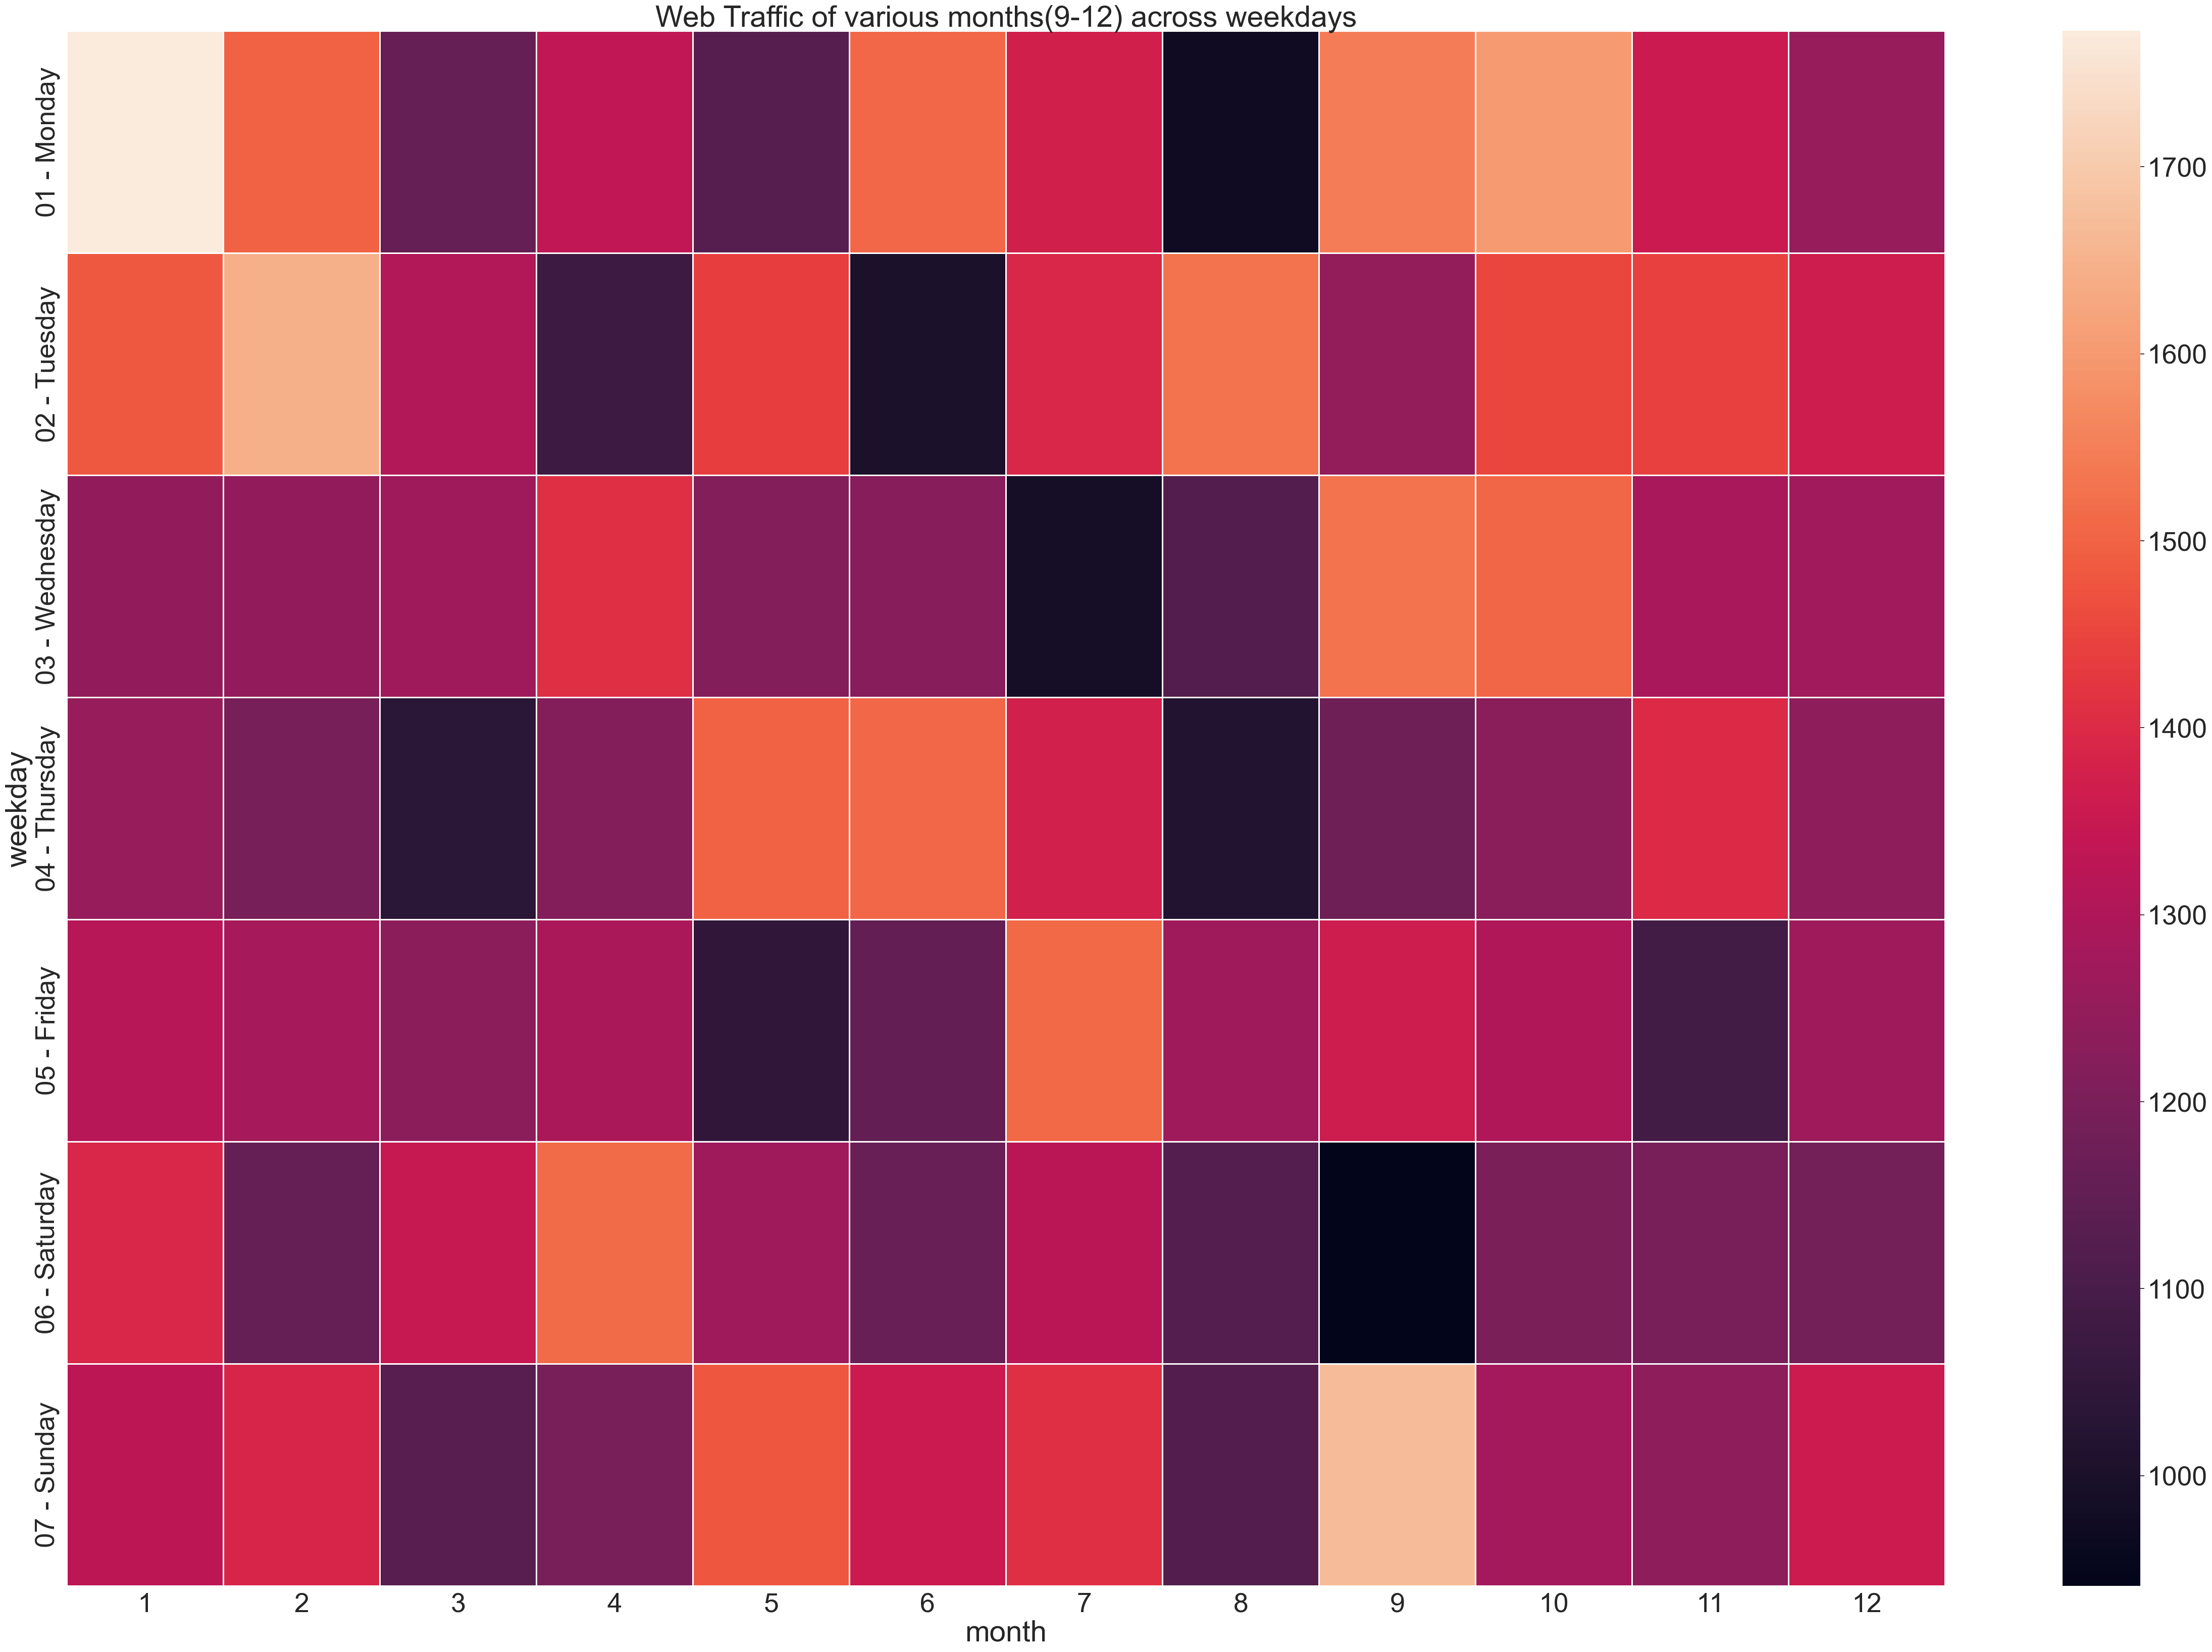

In [176]:
sns.set(font_scale=3.5) 
f, ax = plt.subplots(figsize=(60, 40))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic of various months(9-12) across weekdays')
plt.show()

HAVE TO CHANGE THIS :

We can see that the traffic is maximum on fridays and saturdays on most of the months during the span of Sept to Dec.



In [177]:
cols_to_drop = ['year','month','day','month_num','weekday','weekday','weekday#']
train_data.drop(cols_to_drop,axis=1,inplace=True)
train_data


,Page,Date,Visits
25931609,Competency-based_development_en.wikipedia.org_...,2015-12-26,11.0
6044769,Homúnculo_es.wikipedia.org_mobile-web_all-agents,2015-08-11,394.0
42482337,"Беллуччи,_Моника_ru.wikipedia.org_all-access_s...",2016-04-18,24.0
40124961,ケンブリッジ飛鳥_ja.wikipedia.org_desktop_all-agents,2016-04-02,18.0
38029884,Manual:External_editors/de_www.mediawiki.org_m...,2016-03-19,5.0
...,...,...,...
47568783,荻野目洋子_ja.wikipedia.org_all-access_spider,2016-05-23,122.0
63726355,Special:RecentChangesLinked/How_to_contribute_...,2016-09-12,51.0
37885007,Andy_Schleck_fr.wikipedia.org_all-access_all-a...,2016-03-18,44.0
76392598,平野ノラ_ja.wikipedia.org_desktop_all-agents,2016-12-08,981.0


In [178]:
# top 5 pages with maximum number of views
top_pages = train_data.groupby('Page')['Visits'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Visits')['Page'].tolist()

In [179]:
top5_pages_df = train_data[train_data['Page'].isin(top_pages_list)]
top5_pages_df

,Page,Date,Visits
25380081,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2015-12-22,3061281.0
33793735,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2016-02-18,3106478.0
14725477,Main_Page_en.wikipedia.org_mobile-web_all-agents,2015-10-10,7560220.0
33503609,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2016-02-16,3286279.0
36595056,Special:Search_en.wikipedia.org_all-access_all...,2016-03-09,2328379.0
...,...,...,...
11744159,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2015-09-19,2753420.0
7037138,Main_Page_en.wikipedia.org_mobile-web_all-agents,2015-08-18,7081150.0
62451204,Main_Page_en.wikipedia.org_mobile-web_all-agents,2016-09-03,4662526.0
37755560,Special:Search_en.wikipedia.org_all-access_all...,2016-03-17,2002080.0


In [180]:
#detecting language across page
def detect_language(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'

In [181]:
temp1 = train_data
temp1['Wikipedia_page'] = temp1.Page.apply(detect_language)

In [182]:
def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'

In [183]:
#Creating a new column for decteting the language from the page title
temp1['Page_language'] = temp1.Wikipedia_page.apply(lang_code)

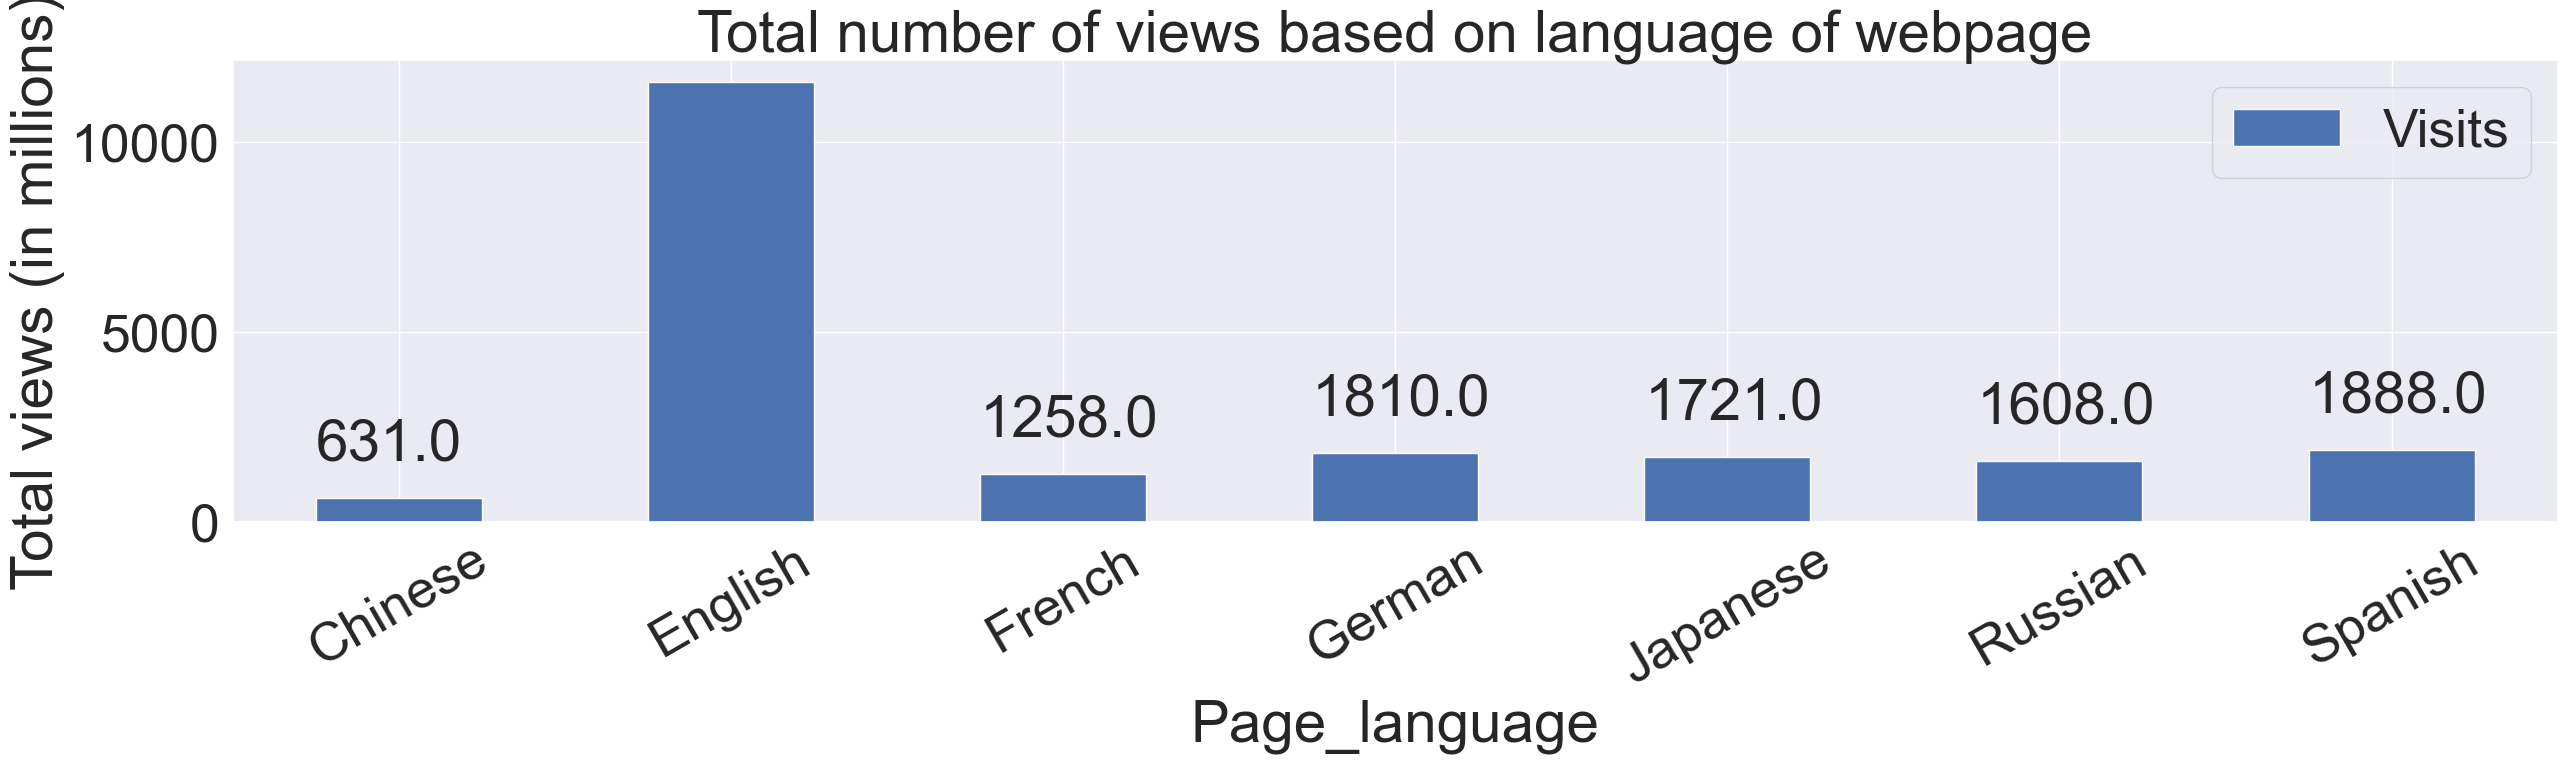

In [184]:
# Total number of views based on language of Wikipedia webpage
fig,ax = plt.subplots(figsize=(30,6))
lang_df = temp1.groupby('Page_language')['Visits'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Visits'] = round(lang_df['Visits']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Visits',rot=30,ax=ax)
bar_graph.set_ylabel('Total views (in millions)')
bar_graph.set_title('Total number of views based on language of webpage')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()+1000))
ax.legend()
plt.show()

In [185]:
top_pages = train_data.groupby('Page')['Visits'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Visits')['Page'].tolist()
print(top_pages_list)

['Main_Page_en.wikipedia.org_all-access_all-agents', 'Main_Page_en.wikipedia.org_desktop_all-agents', 'Main_Page_en.wikipedia.org_mobile-web_all-agents', 'Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents', 'Special:Search_en.wikipedia.org_all-access_all-agents']


In [186]:
top5_pages_df = train_data[train_data['Page'].isin(top_pages_list)]


In [187]:
top5_pages_df


,Page,Date,Visits,Wikipedia_page,Page_language
25380081,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2015-12-22,3061281.0,de,German
33793735,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2016-02-18,3106478.0,de,German
14725477,Main_Page_en.wikipedia.org_mobile-web_all-agents,2015-10-10,7560220.0,en,English
33503609,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2016-02-16,3286279.0,de,German
36595056,Special:Search_en.wikipedia.org_all-access_all...,2016-03-09,2328379.0,en,English
...,...,...,...,...,...
11744159,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2015-09-19,2753420.0,de,German
7037138,Main_Page_en.wikipedia.org_mobile-web_all-agents,2015-08-18,7081150.0,en,English
62451204,Main_Page_en.wikipedia.org_mobile-web_all-agents,2016-09-03,4662526.0,en,English
37755560,Special:Search_en.wikipedia.org_all-access_all...,2016-03-17,2002080.0,en,English


In [188]:
#BEST PAGE
# Time-series of page with maximum views
top_page_df = train_data[train_data.Page == top_pages_list[0]]
#top_page_df = top_page_df['Visits']
top_page_df['Visits'] = top_page_df['Visits'].div(1000000).round(2)
#top_page_df['Visits'] = top_page_df['Visits'].div(1000000).round(2)
top_page_df.drop(['Page','Wikipedia_page','Page_language'],axis=1,inplace=True)
top_page_df.head()


C:\Users\albyd\AppData\Local\Temp\ipykernel_198120\3923570324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_page_df['Visits'] = top_page_df['Visits'].div(1000000).round(2)
C:\Users\albyd\AppData\Local\Temp\ipykernel_198120\3923570324.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_page_df.drop(['Page','Wikipedia_page','Page_language'],axis=1,inplace=True)


,Date,Visits
9177542,2015-09-02,18.42
2939833,2015-07-21,19.74
17591196,2015-10-30,18.18
40656213,2016-04-06,17.03
40075961,2016-04-02,15.13


In [189]:
top_page_df.reset_index(inplace=True)


In [190]:
top_page_df.head()


,index,Date,Visits
0,9177542,2015-09-02,18.42
1,2939833,2015-07-21,19.74
2,17591196,2015-10-30,18.18
3,40656213,2016-04-06,17.03
4,40075961,2016-04-02,15.13


In [191]:
top_page_df.drop('index',axis=1,inplace=True)


C:\Users\albyd\AppData\Local\Temp\ipykernel_198120\4266285378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_page_df.drop('index',axis=1,inplace=True)


In [192]:
top_page_df = top_page_df.set_index('Date')
top_page_df.head()

,Visits
Date,
2015-09-02,18.42
2015-07-21,19.74
2015-10-30,18.18
2016-04-06,17.03
2016-04-02,15.13


(array([ 0., 20., 40., 60., 80.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80')])

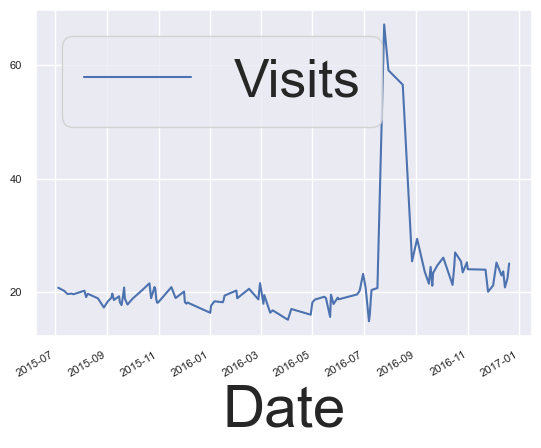

In [193]:
top_page_df.plot()
plt.xticks(fontsize=8)  
plt.yticks(fontsize=8) 

## 3. Anomaly Detection
Using isolation forest since as seen in the figure above, There are anomalies in the data. Using data with anomalies for forecasting will affect the accuracy of the model. Hence anomalies are removed using Isolation forest.

In [194]:
isolation_forest_model = IsolationForest(contamination=0.05)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

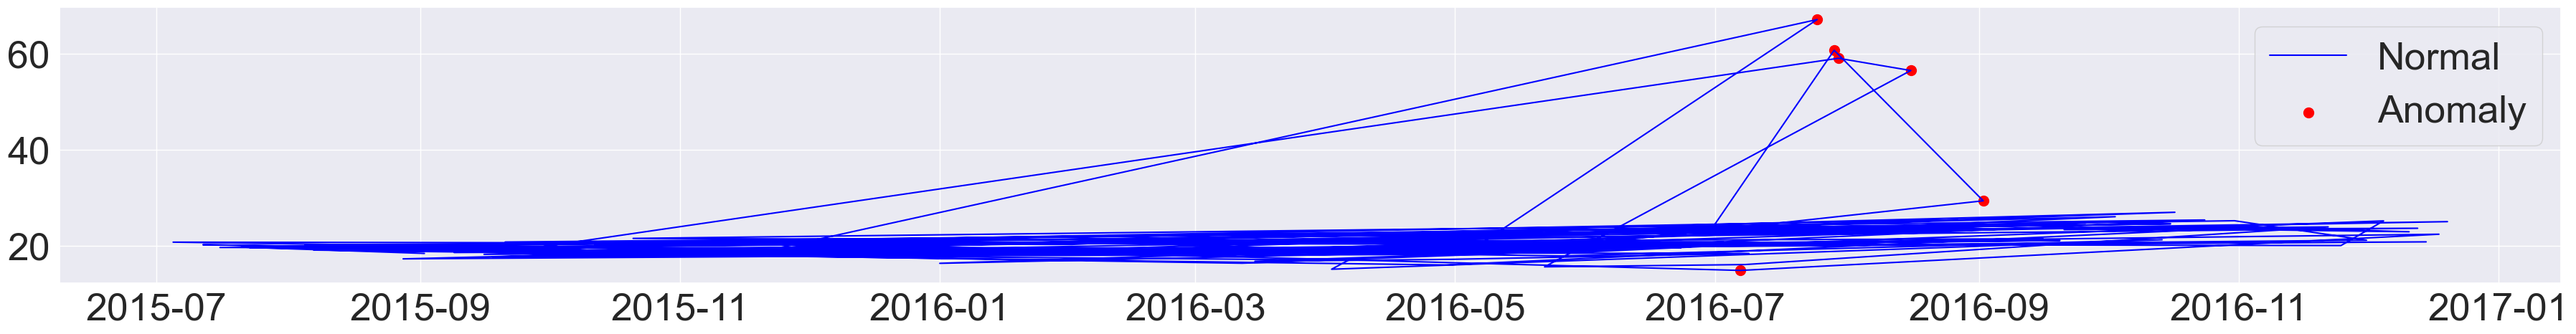

In [195]:
fig, ax = plt.subplots(figsize=(45,5))
anomaly_df = top_page_df.loc[top_page_df['anomaly'] == -1].copy()
ax.plot(top_page_df.index,top_page_df['Visits'],color='blue', label = 'Normal')
plt.scatter(anomaly_df.index,anomaly_df['Visits'],color='red',s=100,label = 'Anomaly')
plt.legend()
plt.show()

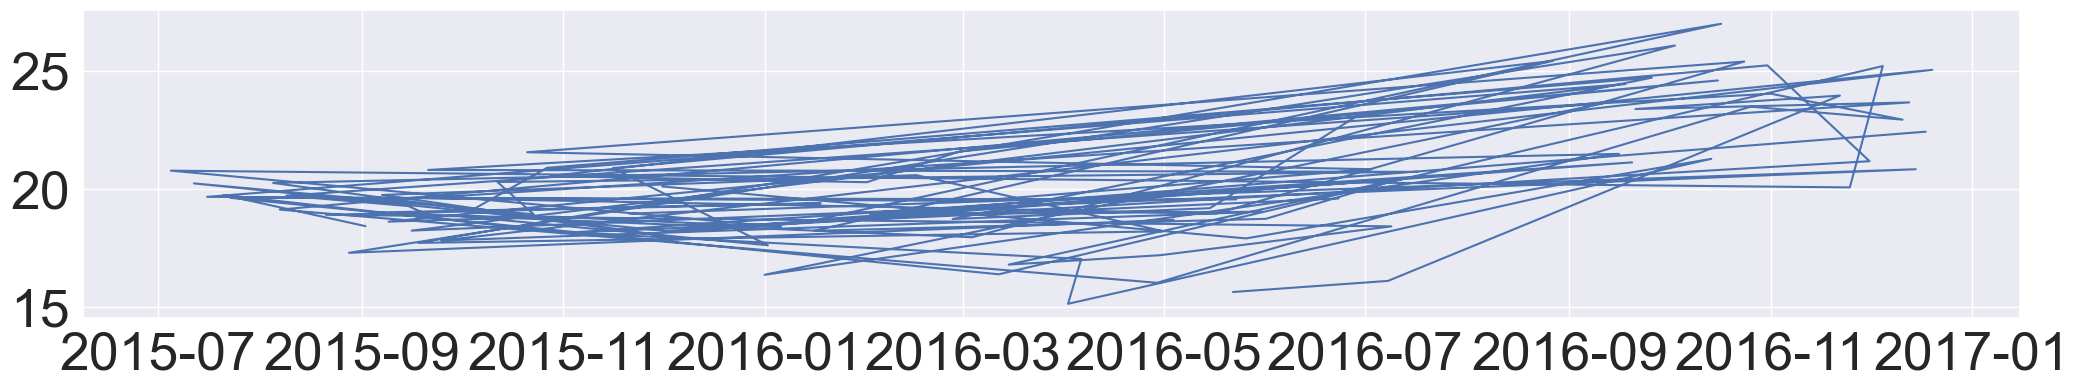

In [196]:
# Removing anomalies from the data
top_page_df['new_visits'] = top_page_df.apply(lambda row: row.Visits if row.anomaly == 1 else None, axis='columns')
plt.figure(figsize=(25,4))
plt.plot(top_page_df.index,top_page_df.new_visits)

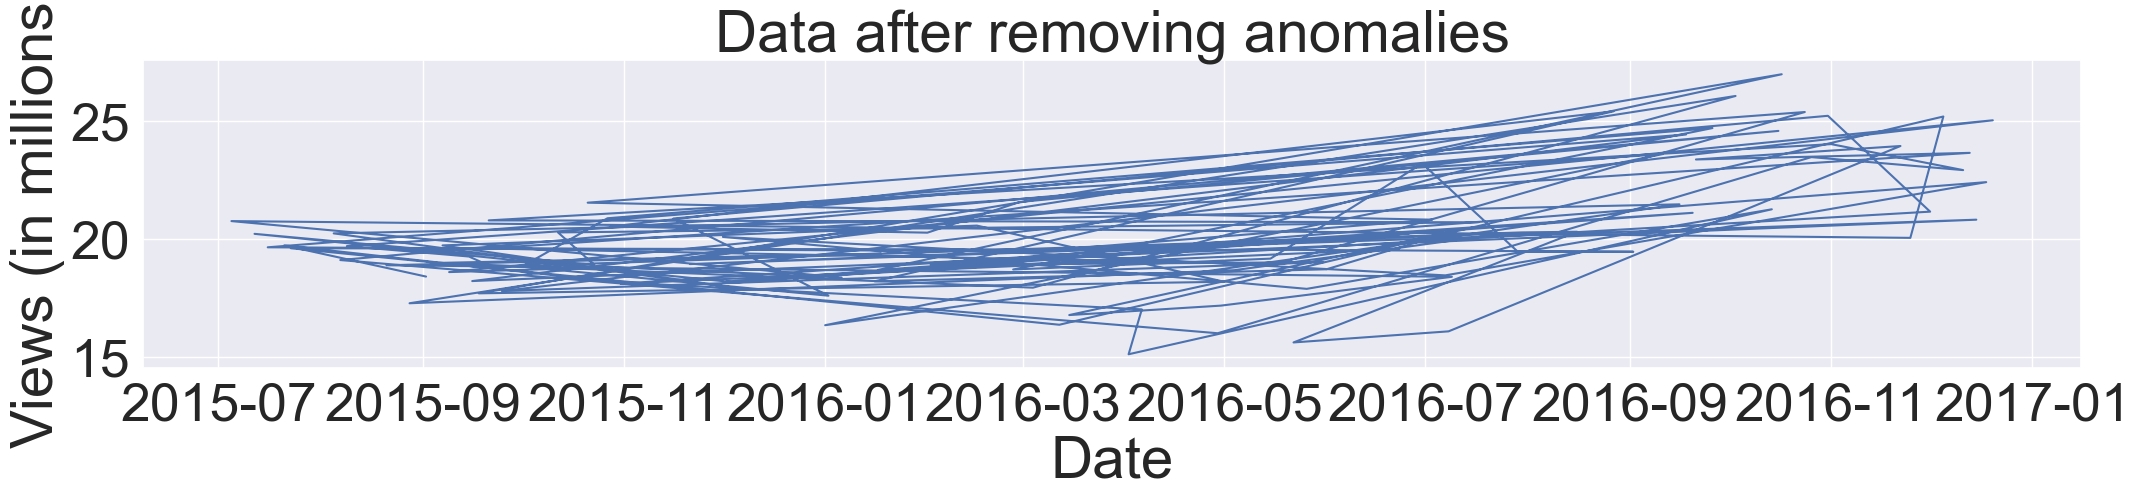

In [197]:
# Filling missing data with rolling mean
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_visits.fillna(top_page_df.new_visits.rolling(30,min_periods=1).mean()))

plt.figure(figsize=(25,4))
plt.plot(top_page_df.index,top_page_df.rolling_mean)
plt.title('Data after removing anomalies')
plt.xlabel('Date')
plt.ylabel('Views (in millions)')
plt.show()

In [198]:
top_page_df = top_page_df.drop(columns=['Visits','anomaly','new_visits']).rename(columns={'rolling_mean':'Views'})


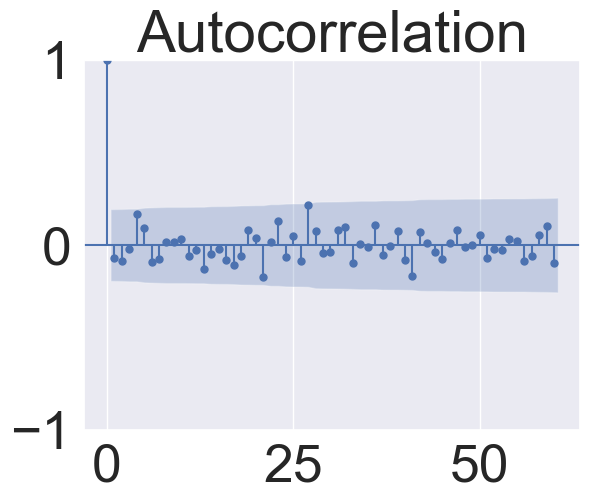

In [199]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

## Augmented Dicky Fuller Test
First element of output is the test statistic. Test statistic shows how likely the data is stationary
Second element indicates the p-value. If p-value is >0.05, reject null hypothesis or else not, The null hypothesis is that data is not stationary.

In [200]:
test = adfuller(top_page_df['Views'])
print(test)

(-7.913716240708387, 3.8862891508103784e-12, 1, 100, {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349}, 413.09046591987163)


The data is not stationary as per the values.



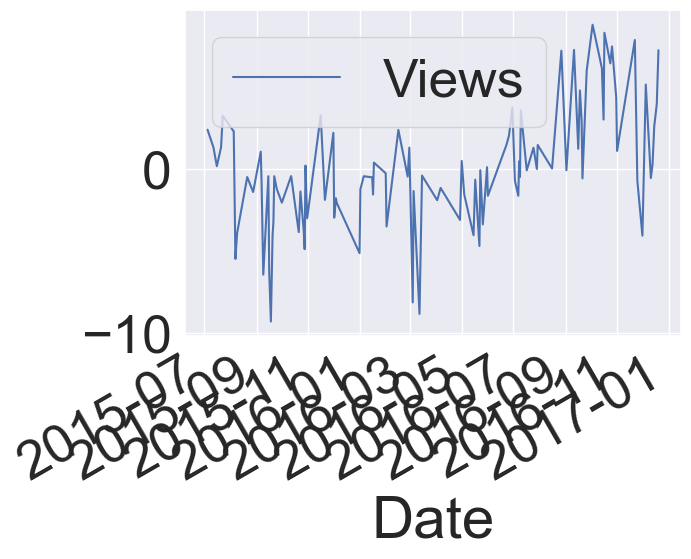

In [201]:
# Differencing the data to make it stationary
top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

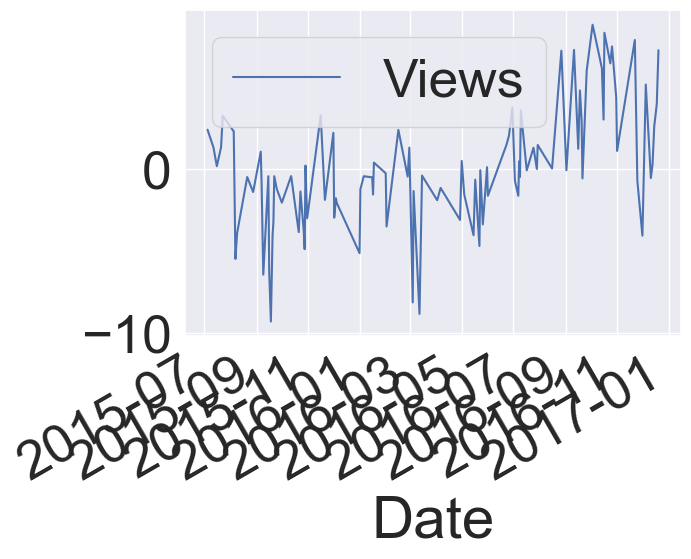

In [202]:
# Differencing the data to make it stationary
top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

In [203]:
# Augmented dicky-fuller test on stationary data
test2 = adfuller(top_page_stationary_df['Views'])
print(test2)

(-10.135842497554105, 8.674278096034697e-18, 3, 97, {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}, 422.84369135161404)


Data is stationary



In [204]:
top_page_df


,Views
Date,
2015-09-02,18.42
2015-07-21,19.74
2015-10-30,18.18
2016-04-06,17.03
2016-04-02,15.13
...,...
2015-07-12,20.23
2015-12-05,18.17
2016-09-20,21.12


In [206]:
top_page_df = top_page_df.sort_index()

In [207]:
# preparing data for modelling
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

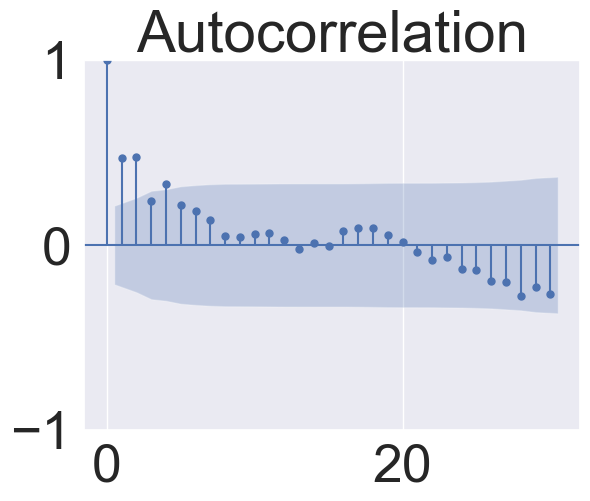

In [208]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

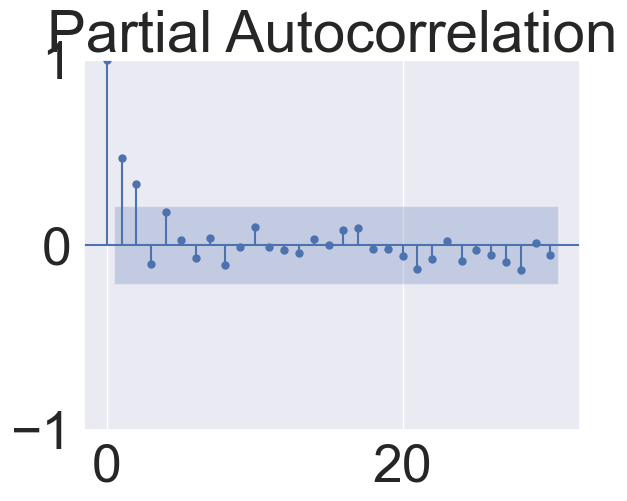

In [209]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

## 4. ARMA Model


In [210]:
aic_bic_values = []
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(train, order=(p,0,q))
            result = model.fit()
            aic_bic_values.append((p,q,result.aic,result.bic))
        except:
            continue

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

In [211]:
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
aic_bic_df = aic_bic_df.sort_values(by=['aic','bic'])

In [212]:
# prediction using ARMA model
model = SARIMAX(train,order=(int(aic_bic_df.iloc[0]['p']),0,int(aic_bic_df.iloc[0]['q'])))
result = model.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [213]:
import pickle
with open('arma_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [214]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()

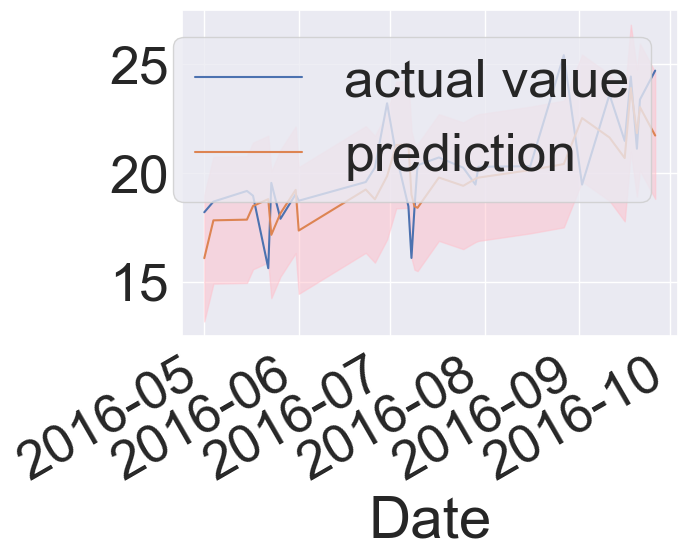

In [215]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax,label='prediction')
plt.fill_between(confidence_interval.index, \
                confidence_interval['lower Views'], \
                confidence_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.legend()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


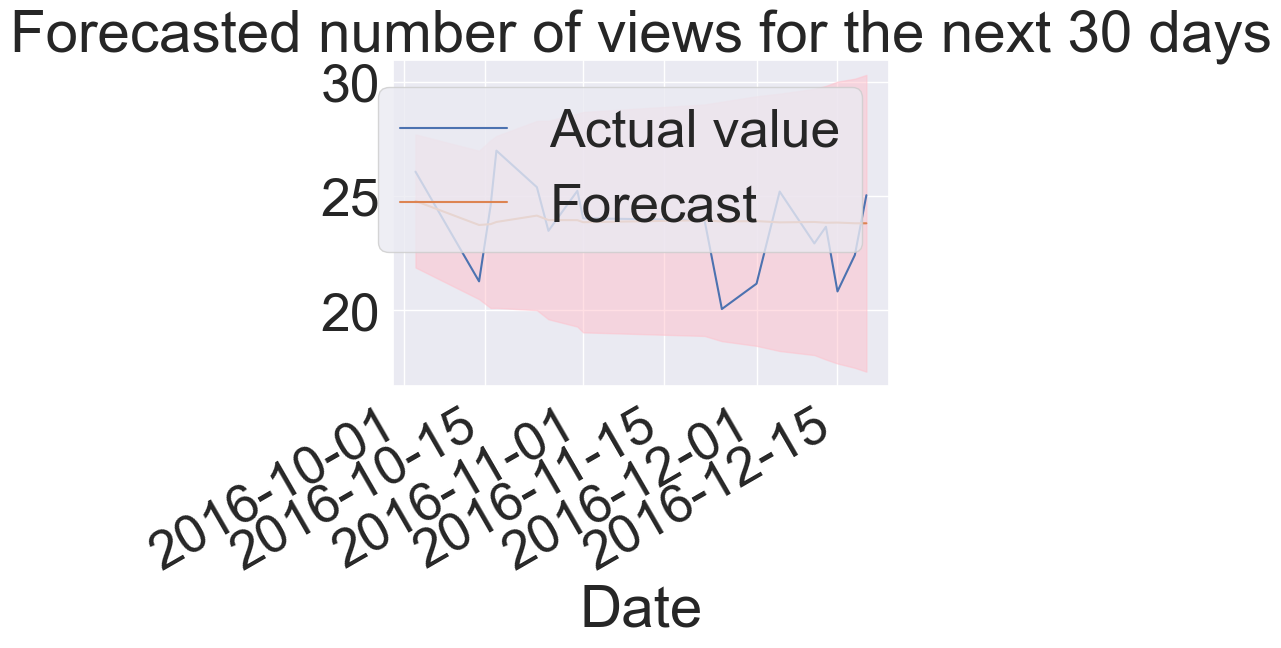

In [217]:
# forecasting using ARMA model
forecast_values = result.get_forecast(steps=test.shape[0])
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

arma_forecast_df = pd.DataFrame({'Date':test.index,'Views':forecast_values.predicted_mean,'lower_views':conf_interval['lower Views'].values,'upper_views':conf_interval['upper Views'].values})
arma_forecast_df = arma_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arma_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax,label='Forecast')
plt.fill_between(arma_forecast_df.index, \
                arma_forecast_df.lower_views, \
                arma_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [218]:
rmse_values = []
rmse_values.append(('ARMA',np.sqrt(np.mean(np.square(forecast_values_mean.values - test.Views.values)))))

In [219]:
print(rmse_values)

[('ARMA', 1.8628054496350461)]


## 5. ARIMA Model


In [220]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(train, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
arima_aic_bic_df = arima_aic_bic_df.sort_values(by=['aic','bic'])

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

In [221]:
#predict using arima
arima_model = SARIMAX(train,order=(int(aic_bic_df.iloc[0]['p']),1,int(aic_bic_df.iloc[0]['q'])))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [222]:
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(arima_model, f)

<Figure size 2400x400 with 0 Axes>

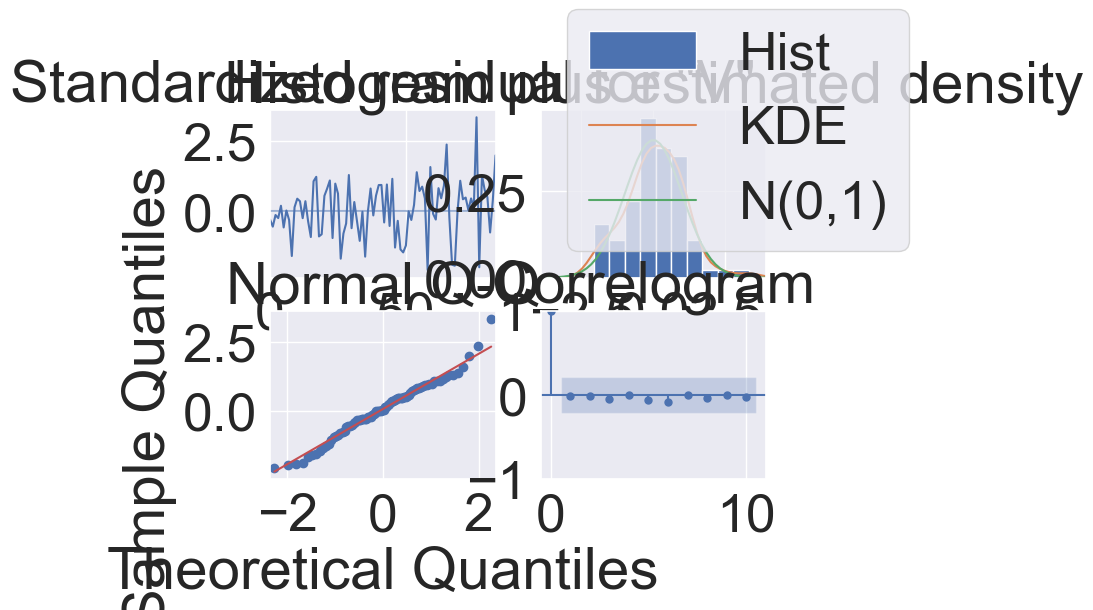

In [223]:
plt.figure(figsize=(24,4))

arima_result.plot_diagnostics()
plt.show()

In [224]:
arima_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Views   No. Observations:                   85
Model:               SARIMAX(4, 1, 0)   Log Likelihood                -152.225
Date:                Sun, 17 Mar 2024   AIC                            314.449
Time:                        14:38:20   BIC                            326.603
Sample:                             0   HQIC                           319.335
                                 - 85                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5471      0.097     -5.651      0.000      -0.737      -0.357
ar.L2         -0.1762      0.122     -1.448      0.148      -0.415       0.062
ar.L3         -0.3966      0.126     -3.136      0.002      -0.644      -0.149
ar.L4         -0.1121      0.152     -0.735      0.462      -0.411       0.187
sigma2         2.1765      0.318      6.852      0.000       1.554       2.799
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.95   Prob(JB):                         0.58
Heteroskedasticity (H):               2.76   Skew:                             0.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

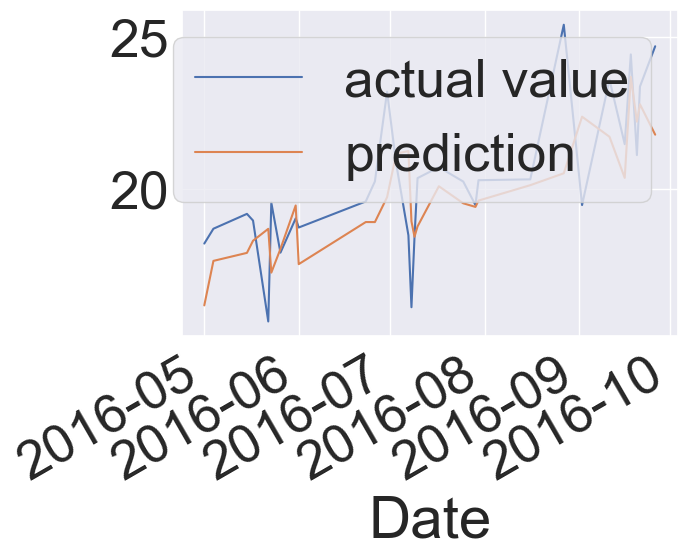

In [225]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean[-30:].plot(ax=ax,label='prediction')
plt.legend()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


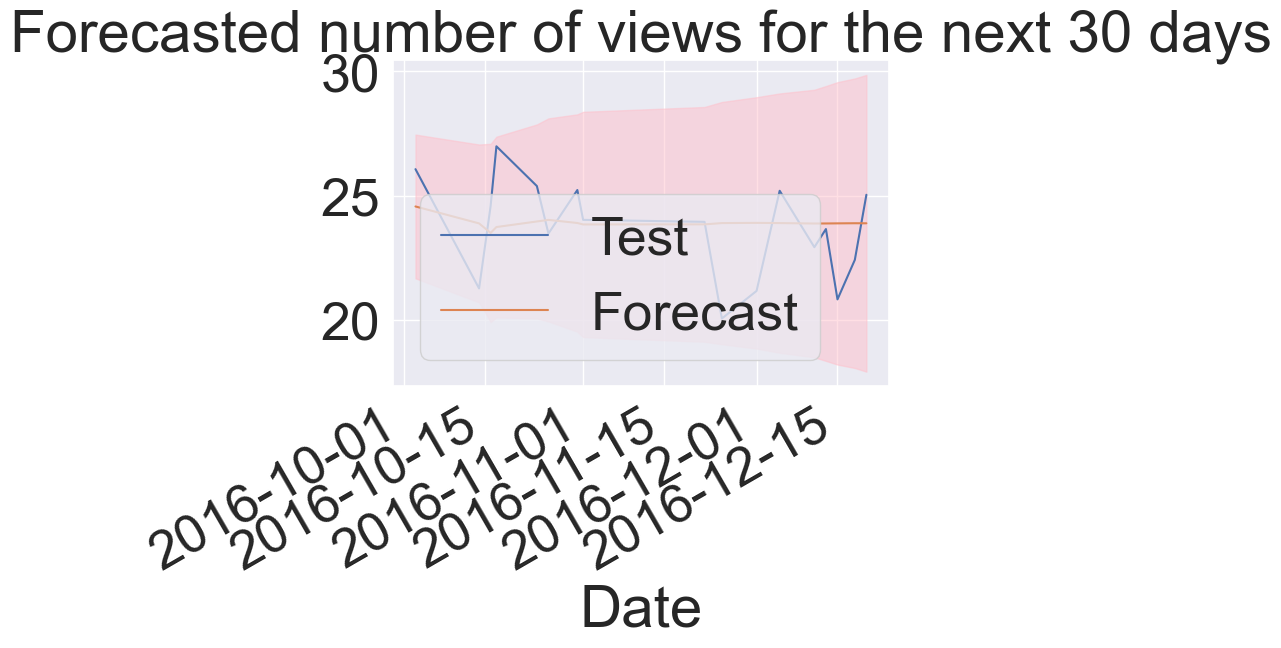

In [226]:
# Forecasting using ARIMA moidel
arima_forecast_values = arima_result.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

arima_forecast_df = pd.DataFrame({'Date':test.index,'Views':arima_forecast_values.predicted_mean,'lower_views':arima_conf_interval['lower Views'].values,'upper_views':arima_conf_interval['upper Views'].values})
arima_forecast_df = arima_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Test'}).plot(ax=ax)
arima_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax)
plt.fill_between(arima_forecast_df.index, \
                arima_forecast_df.lower_views, \
                arima_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [ ]:
rmse_values.append(('ARIMA',np.sqrt(np.mean(np.square(arima_forecast_df.Views.values - test.Views.values)))))


## 6. Exponential smoothing model


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\pandas\util\_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


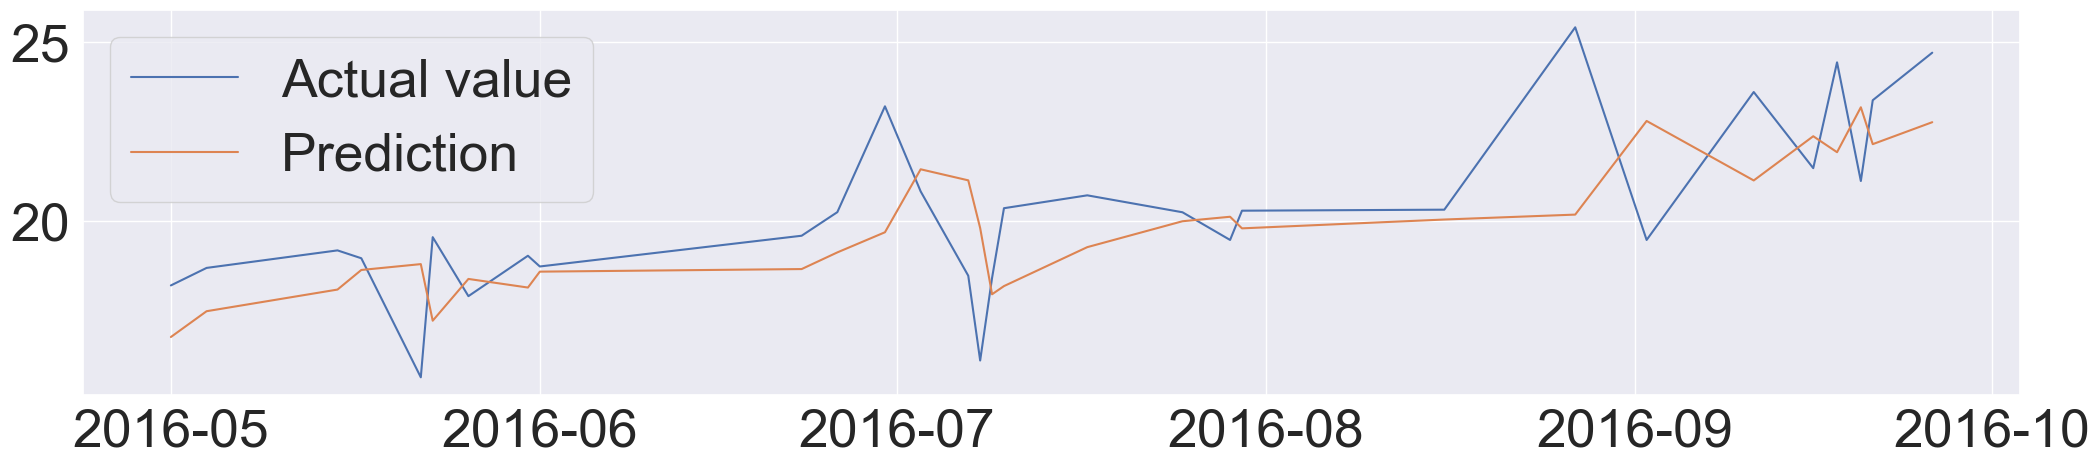

In [228]:
exp_smoothing_model = SimpleExpSmoothing(train)
exp_smoothing_result = exp_smoothing_model.fit(smoothing_level=0.5,optimized=True)

# Prediction using Exponential Smoothing model
exp_smoothing_prediction = exp_smoothing_result.predict(start=train[-30:-29].index[0],end=train[-1:].index[0])

plt.figure(figsize=(25,5))
plt.plot(train[-30:], label='Actual value')
plt.plot(exp_smoothing_prediction, label='Prediction')
plt.legend(loc='best')
plt.show()

In [229]:
with open('exp_smoothing_model.pkl', 'wb') as f:
    pickle.dump(exp_smoothing_model, f)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


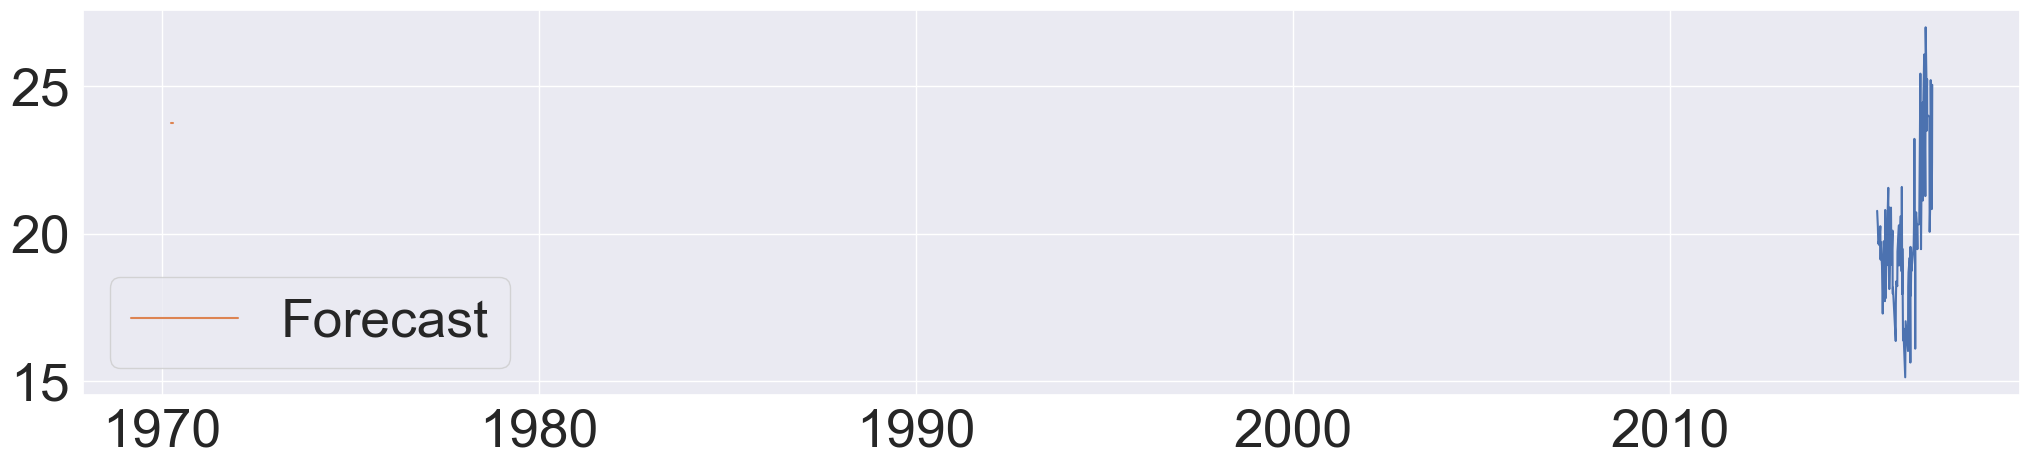

In [230]:
# Forecasting using Exponential smoothing model
exp_smoothing_forecast = exp_smoothing_result.forecast(test.shape[0])
plt.figure(figsize=(25,5))

plt.plot(top_page_df)
plt.plot(exp_smoothing_forecast, label='Forecast')
plt.legend(loc='best')
plt.show()

In [231]:
rmse_values.append(('Exponential Smoothing',np.sqrt(np.mean(np.square(exp_smoothing_forecast.values - test.Views.values)))))


## 8. Auto Arima


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=329.293, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=747.843, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=653.757, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=331.479, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=331.911, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=327.462, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=332.990, Time=0.08 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=327.448, Time=0.19 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=325.469, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=327.222, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=329.160, Time=0.21 se

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


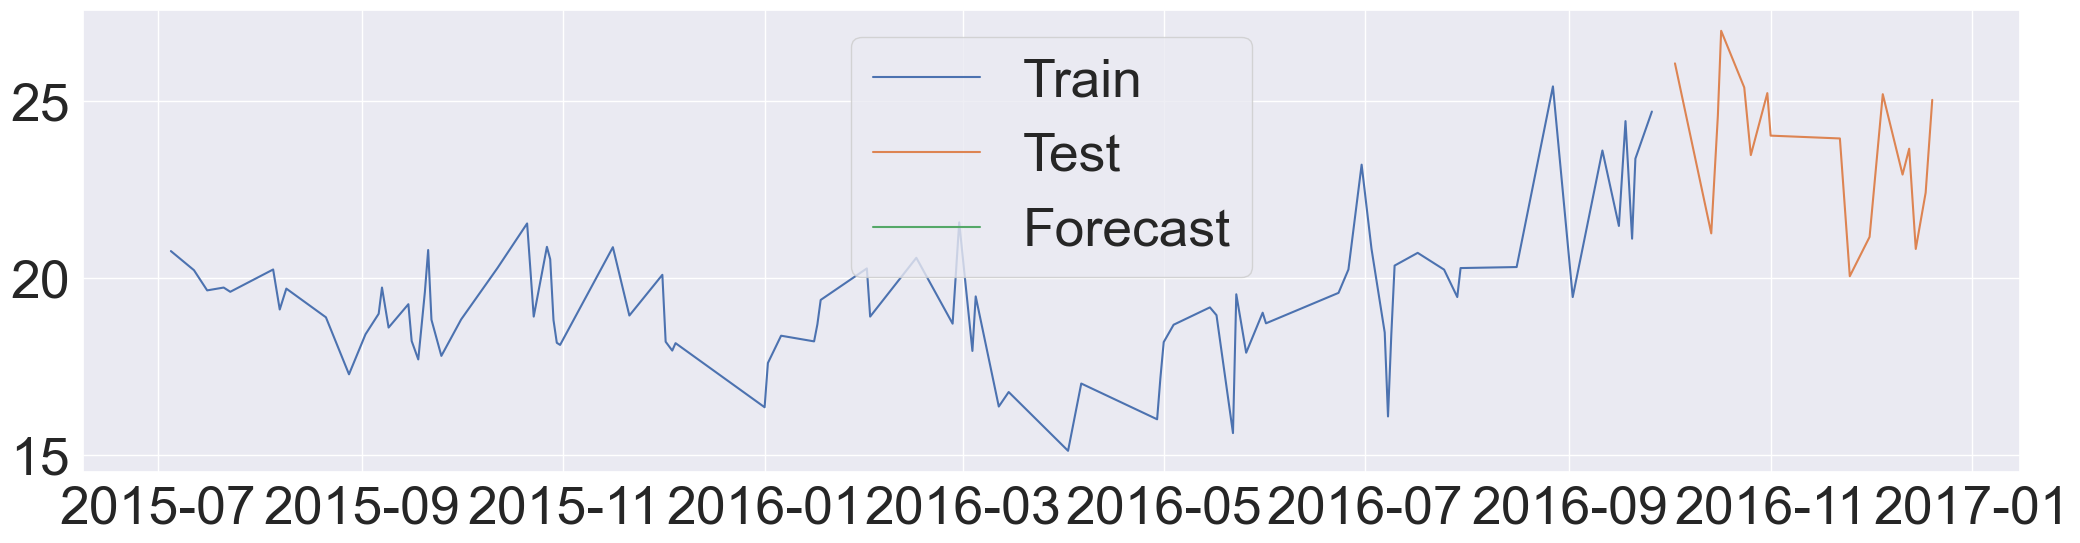

In [232]:
auto_arima_model = auto_arima(train,start_p=2,max_p=7,start_q=2,max_q=7, m=1,stationary=False,trace=True, seasonal=False,error_action='ignore',suppress_warnings=True)
auto_arima_model.fit(train)

auto_arima_forecast = auto_arima_model.predict(n_periods=test.shape[0])
auto_arima_forecast = pd.DataFrame(auto_arima_forecast,index = test.index,columns=['Forecast'])

plt.figure(figsize=(25,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(auto_arima_forecast, label='Forecast')
plt.legend()
plt.show()

In [233]:
with open('auto_arima_model.pkl', 'wb') as f:
    pickle.dump(auto_arima_model, f)

In [234]:
rmse_values.append(('Auto-arima',np.sqrt(np.mean(np.square(auto_arima_forecast.values - test.Views.values)))))


Compairing RMSE values

In [235]:
# RMSE
rmse_df = pd.DataFrame(rmse_values,columns=['Model','RMSE_values']).sort_values('RMSE_values')
rmse_df

,Model,RMSE_values
0,ARMA,1.862805
1,ARIMA,1.920727
2,Exponential Smoothing,1.921854
3,Auto-arima,NaN


## 9. LSTMs


In [236]:
def transform_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [237]:
time_steps = 10


In [238]:
X_train, y_train = transform_dataset(train, train.Views, time_steps)
X_test, y_test = transform_dataset(test, test.Views, time_steps)

In [239]:
# Build the model
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=256,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.RMSprop()
)

In [240]:
# Training the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/200
5/5 [==============================] - 3s 162ms/step - loss: 247.2752 - val_loss: 169.0034
Epoch 2/200
5/5 [==============================] - 0s 16ms/step - loss: 43.0189 - val_loss: 42.7691
Epoch 3/200
5/5 [==============================] - 0s 17ms/step - loss: 4.3849 - val_loss: 22.4752
Epoch 4/200
5/5 [==============================] - 0s 15ms/step - loss: 2.3802 - val_loss: 18.4946
Epoch 5/200
5/5 [==============================] - 0s 15ms/step - loss: 2.4097 - val_loss: 17.4290
Epoch 6/200
5/5 [==============================] - 0s 15ms/step - loss: 2.4464 - val_loss: 16.8427
Epoch 7/200
5/5 [==============================] - 0s 13ms/step - loss: 2.4661 - val_loss: 16.3083
Epoch 8/200
5/5 [==============================] - 0s 12ms/step - loss: 2.4831 - val_loss: 15.8056
Epoch 9/200
5/5 [==============================] - 0s 13ms/step - loss: 2.4984 - val_loss: 15.3704
Epoch 10/200
5/5 [==============================] - 0s 16ms/step - loss: 2.5111 - val_loss: 15.0292
Epoc

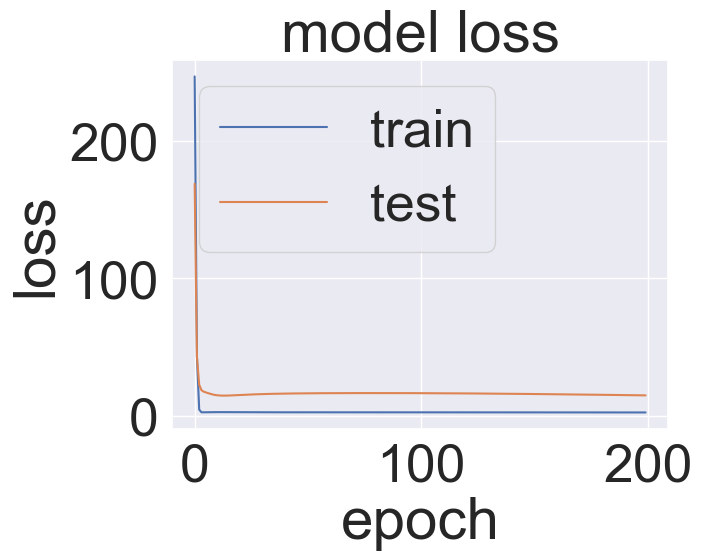

In [241]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [242]:

# Forecasting using test data
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 540ms/step


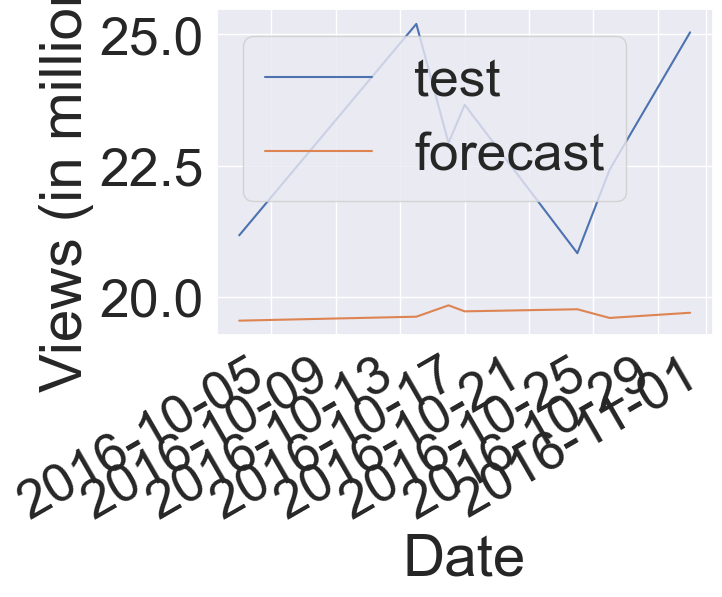

In [243]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'forecast'], loc='upper left')
plt.ylabel('Views (in million)')
plt.show()

In [244]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))


RMSE:3.7137862859696087


## 10. CNN1D


In [245]:
n_features=1
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, n_features)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [246]:
# Training the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/200
5/5 [==============================] - 1s 42ms/step - loss: 177.7691 - val_loss: 124.9321
Epoch 2/200
5/5 [==============================] - 0s 10ms/step - loss: 38.9955 - val_loss: 15.0245
Epoch 3/200
5/5 [==============================] - 0s 9ms/step - loss: 4.7385 - val_loss: 7.1764
Epoch 4/200
5/5 [==============================] - 0s 10ms/step - loss: 17.2463 - val_loss: 8.7463
Epoch 5/200
5/5 [==============================] - 0s 10ms/step - loss: 13.1988 - val_loss: 4.1742
Epoch 6/200
5/5 [==============================] - 0s 10ms/step - loss: 4.1870 - val_loss: 10.2114
Epoch 7/200
5/5 [==============================] - 0s 11ms/step - loss: 3.7410 - val_loss: 17.0088
Epoch 8/200
5/5 [==============================] - 0s 10ms/step - loss: 4.9947 - val_loss: 15.5893
Epoch 9/200
5/5 [==============================] - 0s 9ms/step - loss: 3.8817 - val_loss: 10.0817
Epoch 10/200
5/5 [==============================] - 0s 9ms/step - loss: 2.8949 - val_loss: 6.5418
Epoch 11/2

In [247]:
#forecasting
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 68ms/step


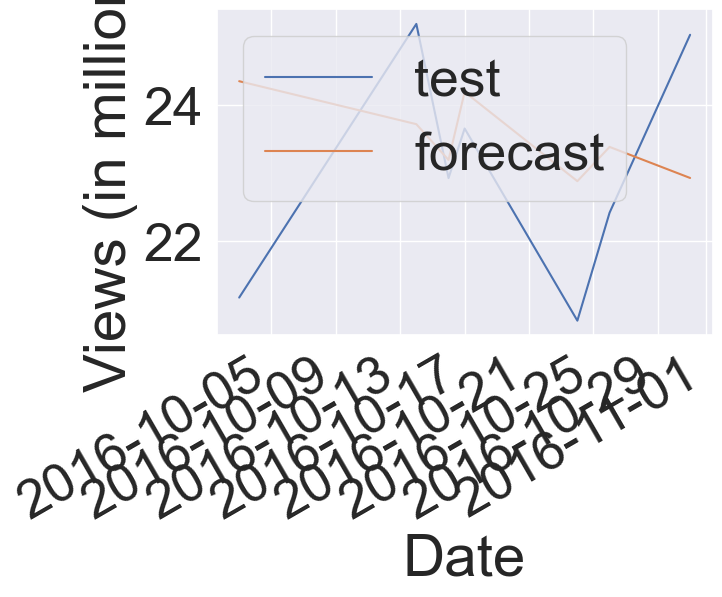

In [248]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'forecast'], loc='upper left')
plt.ylabel('Views (in million)')
plt.show()

In [249]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))


RMSE:1.7848062801446178


## Conclusion

LSTMs outperforms all approaches.

Reference - https://github.com/Suraj520/data-science/blob/main/01-machine-learning/20-web-traffic-time-series-forecast/notebook.ipynb